# Generate Masks on Challenge Data

> We only filter for Hurricane Data

* After completing the EDA, we use this notebook / pipeline to preview and generate masks for the computer vision model to detect damaged buildings, as well as the classes of damage. 
* In the context of image processing and computer vision, a `mask` is a binary or multi-class image that outlines or highlights specific parts of another image.
* While the dataset should include both the original images and the corresponding masks, we also focus on generating a comprehensive set of accurate masks.

In [76]:
# for basic data processing
import pandas as pd
import numpy as np
import json
from shapely import wkt
from shapely.geometry import Polygon

# for image processing & viz
import cv2
import skimage
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# for getting random samples from data
from random import randint

In [7]:
pd.set_option("display.max_columns", None)

### Read Data

* We read in the images data, where each row corresponds to a pre image or post image.
* We also read in the buildings data, where each row corresponds to a building (containing the geometry of the building on the image as a polygon)

We join the building data into image, so that we have an image-level dataset that contains a list of polygons to plot all buildings at once on the image

In [19]:
MAIN_DATA_DIR: str = "/home/jupyter-jhub-admin/data/xview2"
CHALLENGE_DATA_DIR: str = MAIN_DATA_DIR + "/challenge"
PROCESSED_DATA_DIR: str = MAIN_DATA_DIR + "/processed"

print(f"{CHALLENGE_DATA_DIR=}")
print(f"{PROCESSED_DATA_DIR=}")

CHALLENGE_DATA_DIR='/home/jupyter-jhub-admin/data/xview2/challenge'
PROCESSED_DATA_DIR='/home/jupyter-jhub-admin/data/xview2/processed'


In [40]:
img_meta_df = pd.read_parquet(f"{PROCESSED_DATA_DIR}/images.parquet")

# Declaring Image path
img_meta_df["image_path"] = (
    CHALLENGE_DATA_DIR
    + "/"
    + img_meta_df["dataset"]
    + "/images/"
    + img_meta_df["img_name"]
)

# Filtering only hurricane disasters in scope of this project
img_meta_df = img_meta_df[img_meta_df["disaster_sub_type"] == "hurricane"]

print(img_meta_df.shape)
print(img_meta_df.iloc[0]["image_path"])
img_meta_df.head()

(4046, 24)
/home/jupyter-jhub-admin/data/xview2/challenge/hold/images/hurricane-matthew_00000012_pre_disaster.png


,capture_date,gsd,off_nadir_angle,pan_resolution,sun_azimuth,sun_elevation,target_azimuth,disaster,disaster_type,disaster_sub_type,width,height,dataset,image_id,is_pre_image,img_name,id,building_count,no_damage_buildings,minor_damage_buildings,major_damage_buildings,destroyed_buildings,unclassified_buildings,image_path
0,2013-01-05 16:02:21+00:00,1.911686,10.824036,0.476713,160.20961,46.697117,135.871735,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000012,True,hurricane-matthew_00000012_pre_disaster.png,MjU4Mzg2MQ.JfDmqG5_JxvoozHC_uqvD96VaWo,108,0,0,0,0,0,/home/jupyter-jhub-admin/data/xview2/challenge...
1,2013-01-05 16:02:21+00:00,1.911686,10.824036,0.476713,160.20961,46.697117,135.871735,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000015,True,hurricane-matthew_00000015_pre_disaster.png,MjU4MzkzNQ.eGkpU6lYXd1co5g1a8Kqa0GnF_M,3,0,0,0,0,0,/home/jupyter-jhub-admin/data/xview2/challenge...
2,2013-01-05 16:02:21+00:00,1.911686,10.824036,0.476713,160.20961,46.697117,135.871735,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000020,True,hurricane-matthew_00000020_pre_disaster.png,MjU4Mzk2Mw.qyhEB0t3wday68p_qqZuIJ0LBbs,86,0,0,0,0,0,/home/jupyter-jhub-admin/data/xview2/challenge...
3,2013-01-05 16:02:21+00:00,1.911686,10.824036,0.476713,160.20961,46.697117,135.871735,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000024,True,hurricane-matthew_00000024_pre_disaster.png,MjU4Mzk4Mg.xwQHzF2LEQxSVC3oi7-Dm-UvlSc,333,0,0,0,0,0,/home/jupyter-jhub-admin/data/xview2/challenge...
4,2013-01-05 16:02:21+00:00,1.911686,10.824036,0.476713,160.20961,46.697117,135.871735,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000025,True,hurricane-matthew_00000025_pre_disaster.png,MjU4Mzk4NQ.RsNC-j-lQcImj6XqruNjCofqYJw,34,0,0,0,0,0,/home/jupyter-jhub-admin/data/xview2/challenge...


In [22]:
buildings_df = pd.read_parquet(f"{PROCESSED_DATA_DIR}/buildings.parquet")

print(buildings_df.shape)
buildings_df.head()

(272908, 12)


,disaster,disaster_type,disaster_sub_type,id,image_id,img_name,building_id,map_polygon,image_polygon,feature_type,damage,dataset
0,guatemala-volcano,volcano,volcano,MjU0NzE2Nw.m-DFlxQeMVNP1AiBYflHzPY-lgA,guatemala-volcano_00000003,guatemala-volcano_00000003_post_disaster.png,88703461-a33d-4327-9244-a0d4e2242ede,POLYGON ((-90.83554484998086 14.43845885230631...,"POLYGON ((452.9629646916362 86.81005767060303,...",building,minor-damage,test
1,guatemala-volcano,volcano,volcano,MjU0NzE2Nw.m-DFlxQeMVNP1AiBYflHzPY-lgA,guatemala-volcano_00000003,guatemala-volcano_00000003_post_disaster.png,e168e405-3479-44ee-849a-7af2ed32dee1,POLYGON ((-90.83658244456636 14.43748886352666...,"POLYGON ((226.8267143191367 307.8635026276182,...",building,destroyed,test
2,guatemala-volcano,volcano,volcano,MjU0NzE2Nw.m-DFlxQeMVNP1AiBYflHzPY-lgA,guatemala-volcano_00000003,guatemala-volcano_00000003_post_disaster.png,9f8f8916-b6c5-4fa8-ab64-c8fd86eca035,POLYGON ((-90.83487803042956 14.43776515972186...,"POLYGON ((601.0923397346356 241.9779197994199,...",building,minor-damage,test
3,hurricane-florence,flooding,hurricane,MjU0NjYxOA.oDPPzoZ4qHe2KBGmwerMXsQbF9I,hurricane-florence_00000005,hurricane-florence_00000005_post_disaster.png,624f417b-fd9f-4544-ba25-9ba2be361d27,POLYGON ((-79.05237408501472 33.58644838741007...,POLYGON ((43.56144524808627 0.0045224975870225...,building,no-damage,test
4,hurricane-florence,flooding,hurricane,MjU0NjYxOA.oDPPzoZ4qHe2KBGmwerMXsQbF9I,hurricane-florence_00000005,hurricane-florence_00000005_post_disaster.png,557fbd1d-68bf-4776-a1a5-9bbd45cda227,POLYGON ((-79.05057793741786 33.58642007435035...,POLYGON ((406.9497321265795 0.0095005985733089...,building,no-damage,test


In [25]:
img_building_df: pd.DataFrame = img_meta_df.merge(
    buildings_df.drop(
        columns=[
            c
            for c in buildings_df.columns
            if c in img_meta_df.columns and c != "image_id"
        ],
    ),
    "left",
    "image_id",
)

print(img_building_df.shape)
img_building_df.head()

(218132, 29)


,capture_date,gsd,off_nadir_angle,pan_resolution,sun_azimuth,sun_elevation,target_azimuth,disaster,disaster_type,disaster_sub_type,width,height,dataset,image_id,is_pre_image,img_name,id,building_count,no_damage_buildings,minor_damage_buildings,major_damage_buildings,destroyed_buildings,unclassified_buildings,image_path,building_id,map_polygon,image_polygon,feature_type,damage
0,2013-01-05 16:02:21+00:00,1.911686,10.824036,0.476713,160.20961,46.697117,135.871735,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000012,True,hurricane-matthew_00000012_pre_disaster.png,MjU4Mzg2MQ.JfDmqG5_JxvoozHC_uqvD96VaWo,108,0,0,0,0,0,/home/jupyter-jhub-admin/data/xview2/challenge...,ba98856e-9d07-41d1-8a0b-df43e3b700e6,POLYGON ((-73.74876670508114 18.23314387348863...,"POLYGON ((962.5830311402426 732.6440672732887,...",building,minor-damage
1,2013-01-05 16:02:21+00:00,1.911686,10.824036,0.476713,160.20961,46.697117,135.871735,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000012,True,hurricane-matthew_00000012_pre_disaster.png,MjU4Mzg2MQ.JfDmqG5_JxvoozHC_uqvD96VaWo,108,0,0,0,0,0,/home/jupyter-jhub-admin/data/xview2/challenge...,faaf8065-e7fd-4aed-bbbb-28ff2df52c25,POLYGON ((-73.74927438612076 18.23405043614472...,"POLYGON ((850.6483179334692 526.8602300314485,...",building,minor-damage
2,2013-01-05 16:02:21+00:00,1.911686,10.824036,0.476713,160.20961,46.697117,135.871735,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000012,True,hurricane-matthew_00000012_pre_disaster.png,MjU4Mzg2MQ.JfDmqG5_JxvoozHC_uqvD96VaWo,108,0,0,0,0,0,/home/jupyter-jhub-admin/data/xview2/challenge...,75ea79c9-7a31-4794-83be-faaa51e652ef,POLYGON ((-73.74954942051457 18.23455000526948...,"POLYGON ((789.9954070036398 413.4541411046255,...",building,minor-damage
3,2013-01-05 16:02:21+00:00,1.911686,10.824036,0.476713,160.20961,46.697117,135.871735,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000012,True,hurricane-matthew_00000012_pre_disaster.png,MjU4Mzg2MQ.JfDmqG5_JxvoozHC_uqvD96VaWo,108,0,0,0,0,0,/home/jupyter-jhub-admin/data/xview2/challenge...,c37a1fb9-28ac-4630-b830-1fd213a2ba83,POLYGON ((-73.75020061206322 18.23495699426978...,"POLYGON ((647.5971193420658 321.6993047127825,...",building,minor-damage
4,2013-01-05 16:02:21+00:00,1.911686,10.824036,0.476713,160.20961,46.697117,135.871735,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000012,True,hurricane-matthew_00000012_pre_disaster.png,MjU4Mzg2MQ.JfDmqG5_JxvoozHC_uqvD96VaWo,108,0,0,0,0,0,/home/jupyter-jhub-admin/data/xview2/challenge...,504f4680-7cc0-4ad1-b5c9-2c917a308c9b,POLYGON ((-73.74908907387508 18.23460160661307...,"POLYGON ((890.1331975119865 401.0133550977981,...",building,minor-damage


#### Masking Pre-and-Post Images

* **Pre-Image Analysis**: The pre-disaster images (and their corresponding masks) serve as a baseline, showing the condition of buildings and infrastructure before the event. This helps the model understand what "undamaged" structures look like.

* **Post-Image Analysis**: The post-disaster images (and their corresponding masks) reveal the aftermath of the disaster. By comparing these with the pre-disaster baseline, the model can identify changes, damages, and anomalies.

This information is crucial for the model to recognize what constitutes damage or alteration in the post-images

In [68]:
# Aggregate polygons by image_id
img_geometries_df = (
    img_building_df.groupby(["image_id", "image_path", "is_pre_image"])
    .agg(
        {
            "building_id": "nunique",
            "width": "first",
            "height": "first",
            "image_polygon": lambda x: list(x),
            "damage": lambda x: list(x),
        }
    )
    .rename(
        columns={
            "building_id": "building_count",
            "image_polygon": "building_geometries",
        }
    )
    .reset_index()
)

for col_name in ["building_geometries", "damage"]:
    img_geometries_df[col_name] = img_geometries_df[col_name].apply(
        lambda cell: [c for c in cell if c]
    )

img_geometries_df["building_geometries"] = img_geometries_df[
    "building_geometries"
].apply(lambda cell: [wkt.loads(c) for c in cell])

print(img_geometries_df.shape)
img_geometries_df.head()

(4046, 8)


,image_id,image_path,is_pre_image,building_count,width,height,building_geometries,damage
0,hurricane-florence_00000000,/home/jupyter-jhub-admin/data/xview2/challenge...,False,110,1024,1024,[POLYGON ((126.2051261436394 0.006184273110124...,"[no-damage, no-damage, no-damage, no-damage, n..."
1,hurricane-florence_00000000,/home/jupyter-jhub-admin/data/xview2/challenge...,True,110,1024,1024,[POLYGON ((126.2051261436394 0.006184273110124...,"[no-damage, no-damage, no-damage, no-damage, n..."
2,hurricane-florence_00000001,/home/jupyter-jhub-admin/data/xview2/challenge...,False,91,1024,1024,[POLYGON ((404.8428229479346 1022.985470946143...,"[no-damage, no-damage, no-damage, no-damage, n..."
3,hurricane-florence_00000001,/home/jupyter-jhub-admin/data/xview2/challenge...,True,91,1024,1024,[POLYGON ((404.8428229479346 1022.985470946143...,"[no-damage, no-damage, no-damage, no-damage, n..."
4,hurricane-florence_00000002,/home/jupyter-jhub-admin/data/xview2/challenge...,False,6,1024,1024,[POLYGON ((6.826987571875607 544.8866551972654...,"[no-damage, no-damage, no-damage, no-damage, n..."


Simple Data Quality Check to Ensure that all buildings per image have been retrieved for masking

In [69]:
# Check if polygon counts match up with building counts from metadata
assert (
    img_geometries_df[
        img_geometries_df["building_geometries"].str.len()
        != img_geometries_df["building_count"]
    ].shape[0]
    == 0
)

# Check if damage counts match up with building counts from metadata
assert (
    img_geometries_df[
        img_geometries_df["damage"].str.len() != img_geometries_df["building_count"]
    ].shape[0]
    == 0
)

### Declare Function to Preview Images with Building Outlines

* This function takes in the location of an image, the list of polygons (building geometries) to plot, as well as their respective damage classes.
* The polygons and building damage classes are provided as two lists, and the indexes of each list are used to map buildings to their damage type
* It is essential for `polygons` list to be a list of `shapely.geometryy.Polygon` objects, as some shapely functions are used.
* A color-code map is declared to show different buildings with various damage classes with different colored borders.

In [88]:
# Color map for classes
color_map = {
    "no-damage": "white",
    "minor-damage": "yellow",
    "major-damage": "orange",
    "destroyed": "red",
    "unclassified": "grey",
}


def plot_polygons_on_image(image_uri: str, polygons: list[str], classes: list[str]):
    # Create figure with 2 subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Display the first image with polygons
    pre_image = skimage.io.imread(image_uri)
    post_image = skimage.io.imread(image_uri.replace("_pre_", "_post_"))

    ax[0].imshow(pre_image)

    # Add a patch for each polygon with color coding based on the class
    for polygon, class_name in zip(polygons, classes):
        # Fetch the color for the class
        color = color_map.get(
            class_name, "grey"
        )  # Default to grey if class is not recognized
        # Convert polygon points to a matplotlib patch
        exterior = polygon.exterior.coords.xy
        patch = patches.Polygon(
            xy=list(zip(exterior[0], exterior[1])),
            closed=True,
            edgecolor=color,
            fill=False,
        )
        ax[0].add_patch(patch)

    # Display the post image without polygons
    ax[1].imshow(post_image)

    plt.tight_layout()
    plt.show()

### Preview Buildings on Image

The cell belows allows us to see different images, overlaid with buildings outlines color coded by damage. 

* If `sample_img` parameter is not set, it finds and displays a random pre-and-post image from the dataset, with the pre-image labeled with geometries
* If `sample_img` is labeled with an `image_id`, then that image is shown 

1157
/home/jupyter-jhub-admin/data/xview2/challenge/train/images/hurricane-matthew_00000089_pre_disaster.png


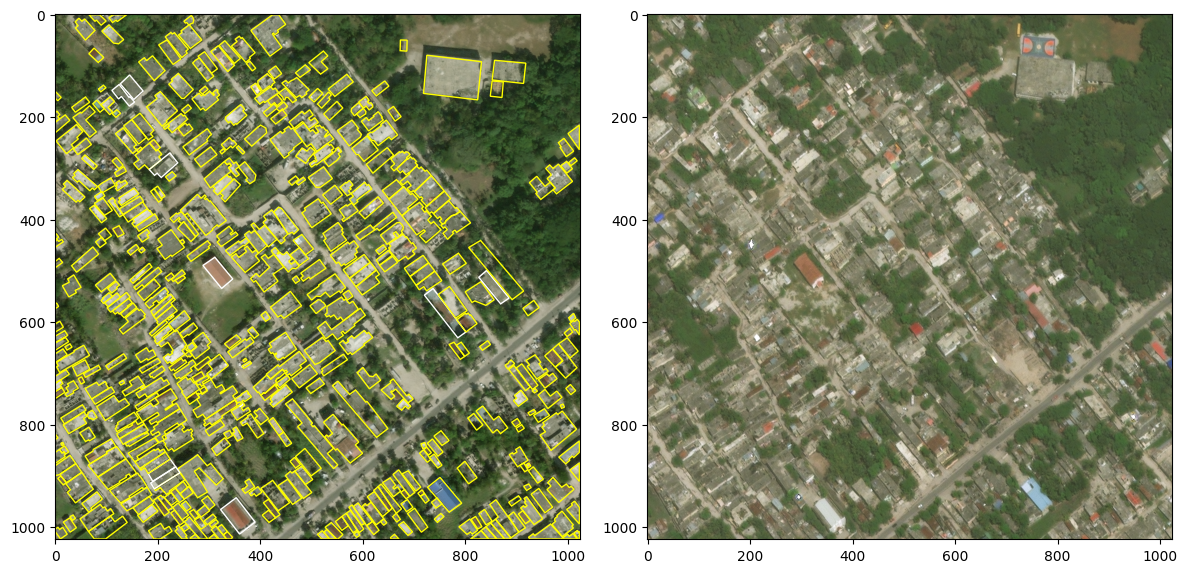

In [113]:
unique_img_geometries = img_geometries_df[
    img_geometries_df["is_pre_image"] == True
].reset_index(drop=True)

# Leave this parameter empty to choose a random image. Fill it with an image ID to see masks for that image.
sample_img: str = "hurricane-matthew_00000089"

random_sample: int = (
    randint(0, len(unique_img_geometries))
    if not sample_img
    else unique_img_geometries[unique_img_geometries["image_id"] == sample_img].index[0]
)
print(random_sample)
print(unique_img_geometries.iloc[random_sample]["image_path"])



plot_polygons_on_image(
    unique_img_geometries.iloc[random_sample]["image_path"],
    unique_img_geometries.iloc[random_sample]["building_geometries"],
    unique_img_geometries.iloc[random_sample]["damage"],
)

#### Samples of Interest

* `hurricane-matthew_00000089` - very many minor damaged buildings
* `hurricane-harvey_00000006` - minor damage shown but nothing evident from image
* `hurricane-michael_00000107` - clear highly damaged buildings
* `hurricane-michael_00000461` - cars
* `hurricane-matthew_00000369` - cloud + river skewed
* `hurricane-florence_00000188` - buildings flooded